# Hire-Gutnisky-2015 - A DataJoint example
This notebook presents data and results associated with the following papers:
>Samuel Andrew Hires, Diego A Gutnisky, Jianing Yu, Daniel H O’Connor, and Karel Svoboda. "Low-noise encoding of active touch by
layer 4 in the somatosensory cortex" (2015) eLife (http://doi.org/10.7554/eLife.06619)

Original data shared here: http://crcns.org/data-sets/ssc/ssc-5/about-ssc-5

The data in original MATLAB format (.mat) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. 
 

In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis, virus,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


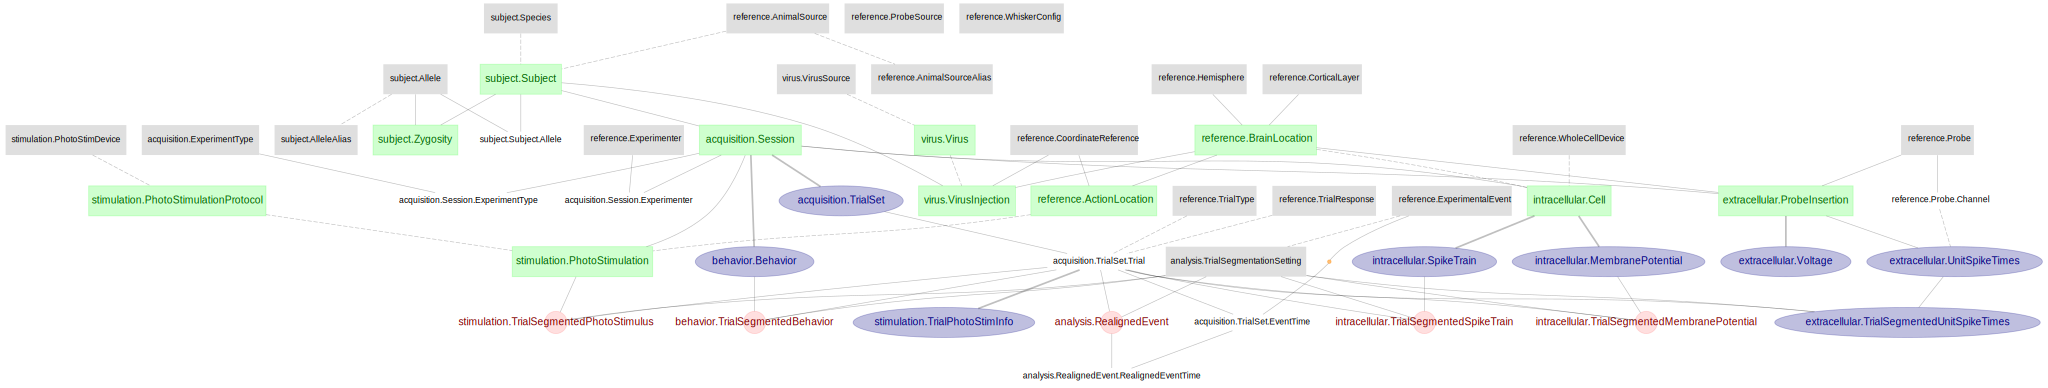

In [2]:
all_erd = (dj.ERD(reference) + dj.ERD(subject) + dj.ERD(virus)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Reproducing Figure 1B, C, E

### Select an example cell recording session - "Cell 23"

In [135]:
session_key = acquisition.Session & 'session_id="Cell23"'

In [136]:
trial_key = acquisition.TrialSet.Trial & session_key & 'trial_id=78'

In [137]:
# Specify segmentation setting to align to "trial_start" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'trial_start',
                                                      'pre_stim_duration': 0,
                                                      'post_stim_duration': 4}).fetch1()

### Figure 1A

In [138]:
# Get segmented Membrane Potential and Spike Train
mp = (intracellular.TrialSegmentedMembranePotential & trial_key & seg_param_key).fetch1('segmented_mp')
behav = (behavior.TrialSegmentedBehavior & trial_key & seg_param_key).fetch1()

In [139]:
# Get sampling rate
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               mp.size)
behav_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               behav['segmented_amplitude'].size)

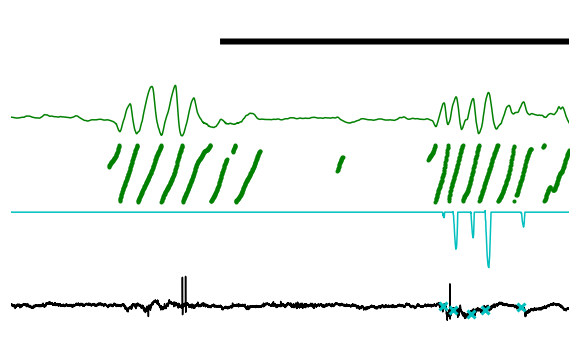

In [140]:
fig1a, axs = plt.subplots(5, 1, figsize=(10, 6))
fig1a.subplots_adjust(hspace=0.05)
axs[0].plot(behav_timestamps, np.where(behav['segmented_pole_available'] > 0, behav['segmented_pole_available'], np.nan), 'k',
           linewidth=6)
axs[1].plot(behav_timestamps, behav['segmented_theta_at_base'], 'g')
axs[2].plot(behav_timestamps, np.where(behav['segmented_amplitude'] > 2.5, behav['segmented_phase'], np.nan), '.g')
axs[3].plot(behav_timestamps, behav['segmented_delta_kappa'], 'c')
axs[4].plot(ephys_timestamps, mp, 'k')
axs[4].plot(behav_timestamps, np.where(behav['segmented_touch_onset'] == 1, mp[::10][:-10], np.nan), 'xc', 
            markeredgewidth=3, markersize=8)
for a in axs:
    a.set_xlim((0, 2))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.set_xticks([])
    a.set_yticks([])

### Figure 1C, D

In [141]:
# get spike-train
spk = (intracellular.TrialSegmentedSpikeTrain & session_key & seg_param_key).fetch('segmented_spike_train')
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               spk[0].size)

In [142]:
# restructure data for spike raster  
trial_idx, spike_times = zip(*((np.full_like(r, ri), r)
                                        for ri, r in enumerate(ephys_timestamps[np.where(r > 0)[0]] for r in spk)))
trial_idx = np.hstack(trial_idx)
spike_times = np.hstack(spike_times) 

In [143]:
# trial-average spike histogram
def build_PSTH(spike_train, timestamps, timerange, bin_size=0.05):
    spk_counts, spk_edges = np.histogram(np.hstack(timestamps[np.where(r > 0)[0]] for r in spike_train),
                                         bins=int((timerange[-1] - timerange[0]) / bin_size)
                                         , range=timerange)
    spk_rates = spk_counts / np.diff(spk_edges) / len(spk)
    return spk_rates, spk_edges[:-1]

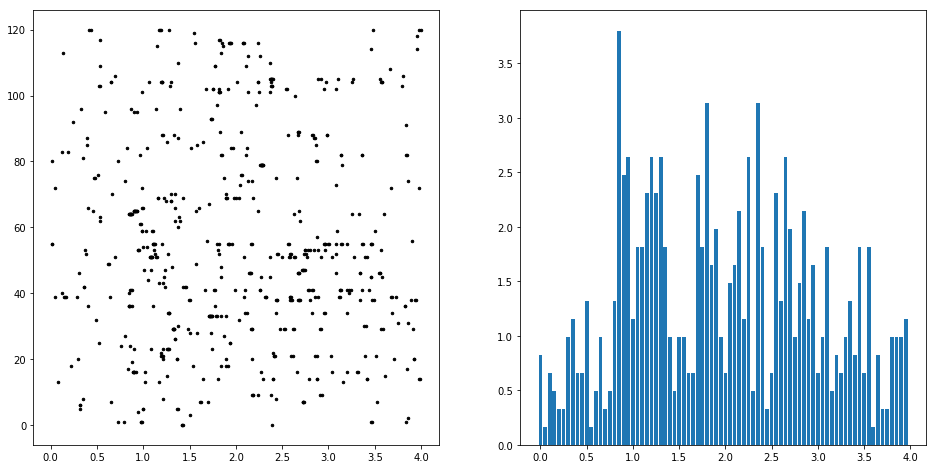

In [144]:
spk_rates, spk_edges = build_PSTH(spk, ephys_timestamps, (ephys_timestamps[0], ephys_timestamps[-1]), bin_size=0.05)
fig1cd, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(spike_times, trial_idx , '.k', markersize=5)
ax[1].bar(spk_edges, spk_rates, width=0.04);

### Figure 1E

In [145]:
# Specify segmentation setting to align to "first lick" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'first_lick',
                                                      'pre_stim_duration': 1,
                                                      'post_stim_duration': 4}).fetch1()

In [146]:
# get spike-train
spk = (intracellular.TrialSegmentedSpikeTrain & session_key & seg_param_key).fetch('segmented_spike_train')
touchon = (behavior.TrialSegmentedBehavior & session_key & seg_param_key).fetch('segmented_touch_onset')
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               spk[0].size)

In [147]:
# get touch duration (last-touch - first-touch)
touch_dur = [np.diff(np.where(r > 0)[0][[0, -1]])[0] if np.where(r > 0)[0].size > 0 else -1 for r in touchon]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [148]:
# sort trials based on touch duration
spk = spk[np.argsort(touch_dur)]

In [149]:
# restructure data for spike raster  
trial_idx, spike_times = zip(*((np.full_like(r, ri), r)
                                        for ri, r in enumerate(ephys_timestamps[np.where(r > 0)[0]] for r in spk)))
trial_idx = np.hstack(trial_idx)
spike_times = np.hstack(spike_times) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


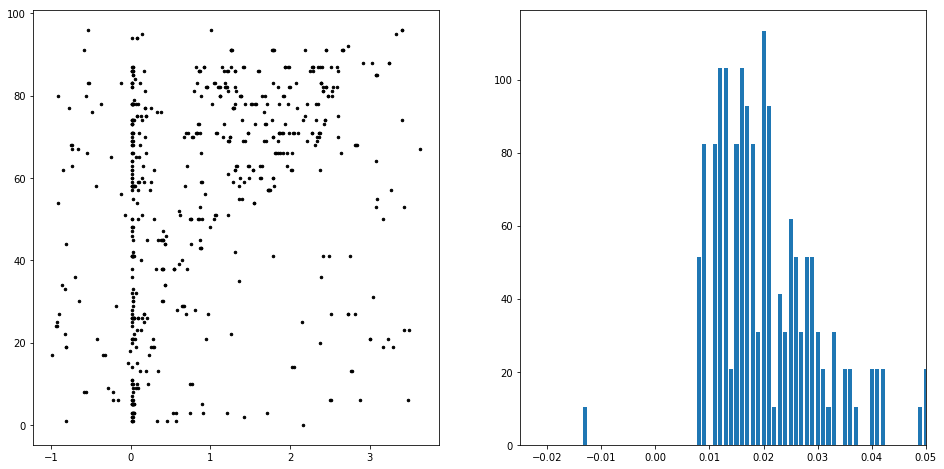

In [150]:
spk_rates, spk_edges = build_PSTH(spk, ephys_timestamps, (ephys_timestamps[0], ephys_timestamps[-1]), bin_size=0.001)
fig1ef, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(spike_times, trial_idx , '.k', markersize=5)
ax[1].bar(spk_edges, spk_rates, width=0.00075);
ax[1].set_xlim((-0.025, 0.05));

## Figure 2 - Population

### Get recordings of cell population in categories:
+ L4 C2-inside
+ L4 C2-outside
+ L5 C2-inside

In [68]:
l4_c2_inside_sess = intracellular.Cell & {'brain_subregion': 'C2', 'cortical_layer': 4}
l4_c2_outside_sess = intracellular.Cell & {'brain_subregion': 'surround', 'cortical_layer': 4}
l5_c2_inside_sess = intracellular.Cell & {'brain_subregion': 'C2', 'cortical_layer': 5}

In [69]:
print(f'Number of L4 C2-inside cells: {len(l4_c2_inside_sess)}')
print(f'Number of L4 C2-outside cells: {len(l4_c2_outside_sess)}')
print(f'Number of L5 C2-inside cells: {len(l5_c2_inside_sess)}')

Number of L4 C2-inside cells: 31
Number of L4 C2-outside cells: 10
Number of L5 C2-inside cells: 11


In [70]:
# Specify segmentation setting to align to "first lick" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'first_lick',
                                                      'pre_stim_duration': 1,
                                                      'post_stim_duration': 4}).fetch1()

### Prepare to plot figure 2A

In [71]:
# get spike-train from all trials from all cells - population level
l4_c2_inside_spk = [(intracellular.TrialSegmentedSpikeTrain & s & seg_param_key).fetch('segmented_spike_train')
                    for s in l4_c2_inside_sess]
l4_c2_outside_spk = [(intracellular.TrialSegmentedSpikeTrain & s & seg_param_key).fetch('segmented_spike_train')
                     for s in l4_c2_outside_sess]
l5_c2_inside_spk = [(intracellular.TrialSegmentedSpikeTrain & s & seg_param_key).fetch('segmented_spike_train')
                    for s in l5_c2_inside_sess]

In [82]:
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               l4_c2_inside_spk[0][0].size)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


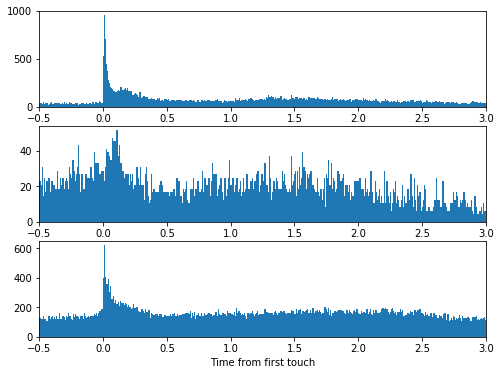

In [228]:
fig2a, axs = plt.subplots(3, 1, figsize=(8, 6))
for ax, spike_train in zip(axs, (np.hstack(l4_c2_inside_spk), np.hstack(l4_c2_outside_spk), np.hstack(l5_c2_inside_spk))):
    spk_rates, spk_edges = build_PSTH(spike_train, ephys_timestamps, (ephys_timestamps[0], ephys_timestamps[-1]), bin_size=0.005)
    ax.bar(spk_edges, spk_rates, width=0.01)
    ax.set_xlim((-0.5, 3));
axs[-1].set_xlabel('Time from first touch');

### Prepare to plot figure 2B

In [298]:
PSTH_matrix = [build_PSTH(s, ephys_timestamps, (-0.025, 0.05), bin_size=0.0005)
               for s in (l4_c2_inside_spk + l4_c2_outside_spk + l5_c2_inside_spk) if s.size > 0]
cell_spk_edge = PSTH_matrix[0][1]
cell_spk_rate = np.vstack(s[0] / s[0].max() for s in PSTH_matrix)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


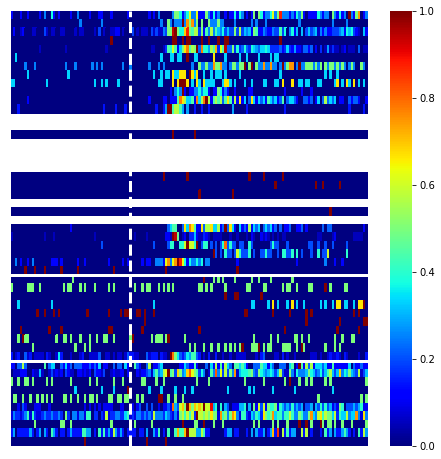

In [299]:
fig2b, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cell_spk_rate, cmap='jet', ax=ax, xticklabels=[], yticklabels=[])
# ax.imshow(cell_spk_rate, cmap='jet')
ax.axvline(x=np.where(np.abs(cell_spk_edge-0)<1e-15)[0][0], color='w',linestyle='--',linewidth=3)
for yv in np.cumsum([len(s) for s in (l4_c2_inside_spk, l4_c2_outside_spk, l5_c2_inside_spk)]):
    ax.axhline(y=yv, color='w',linestyle='-',linewidth=3)